In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
import torch
import csv
import numpy as np
import random
import time
import datetime
import pprint

In [3]:
config = {
    'data_dir': os.path.join("/content/gdrive/MyDrive/Progetti accademici, papers/propaganda_detection-master", "datasets"),
    'model_dir': os.path.join("/content/gdrive/MyDrive/Progetti accademici, papers/propaganda_detection-master", "model_dir"),
}


# Ensure model directory exists
if not os.path.exists(config['model_dir']):
    os.makedirs(config['model_dir'])

In [4]:
# Data Reading Functions
def read_articles(dir_name):
    articles = []
    article_ids = []
    try:
        train_dir = os.path.join(config['data_dir'], dir_name)
        for filename in sorted(os.listdir(train_dir)):
            with open(os.path.join(train_dir, filename), 'r') as myfile:
                articles.append(myfile.read())
                article_ids.append(filename[7:-4])
    except Exception as e:
        print(f"Error reading articles: {e}")
    return articles, article_ids

In [5]:
# Read training span labels
def read_spans(mode=None):
    spans = []
    techniques = []
    label_dir = config['data_dir'] + ("/dev-task-TC-template.out" if mode == "test" else "/train-labels-task2-technique-classification")
    try:
        for filename in sorted(os.listdir(label_dir)):
            with open(os.path.join(label_dir, filename), 'r') as myfile:
                tsvreader = csv.reader(myfile, delimiter="\t")
                span, technique = [], []
                for row in tsvreader:
                    span.append((int(row[2]), int(row[3])))
                    technique.append(row[1] if mode != "test" else "Slogans")  # Dummy for test
                spans.append(span)
                techniques.append(technique)
    except Exception as e:
        print(f"Error reading spans: {e}")
    return spans, techniques

In [6]:
# Read training span labels
def read_test_spans():
    spans = []
    techniques = []
    label_file = os.path.join(config['data_dir'], "dev-task-TC-template.out")
    try:
        with open(label_file, 'r') as myfile:
            tsvreader = csv.reader(myfile, delimiter="\t")
            span = []
            technique = []
            for row in tsvreader:
                article_index = int(row[0])
                if 'prev_index' not in locals() or prev_index != article_index:
                    if 'prev_index' in locals():
                        spans.append(span)
                        techniques.append(technique)
                    prev_index = article_index
                    span = []
                    technique = []
                span.append((int(row[2]), int(row[3])))
                technique.append("Slogans")  # Using a placeholder value for demonstration
            if span:
                spans.append(span)
                techniques.append(technique)
    except Exception as e:
        print(f"Error reading test spans: {e}")
    return spans, techniques

In [7]:
def get_context(article, span, mode=None):
  def get_num_words(sentence):
    return len(sentence.split(' '))
  if mode == "title":
    return article.split('\n')[0]
  if mode == "sentence":
    WORD_LEN_LIMIT = 120
    li = span[0]
    ri = span[1]
    span_text = article[li: ri]
    num_words = get_num_words(span_text)
    if num_words >= WORD_LEN_LIMIT:
      return span_text
    remaining_len = WORD_LEN_LIMIT - num_words
    lhs_words = remaining_len // 2
    rhs_words = remaining_len - lhs_words
    li -= 1
    lcount = 0
    while li >= 0 and article[li] != '\n' and lcount < lhs_words:
      if article[li] == ' ':
        lcount += 1
      li -= 1
    ri += 1
    rcount = 0
    while ri < len(article) and article[ri] != '\n' and rcount < rhs_words:
      if article[ri] == ' ':
        rcount += 1
      ri += 1
    return article[li+1: ri - 1]

  return ""

In [8]:
def get_examples(articles, spans, techniques, context_mode=None):
  assert len(articles) == len(spans) and len(spans) == len(techniques)
  sentences = []
  labels = []
  sent_contexts = []
  for index, article in enumerate(articles):
    span = spans[index]
    technique = techniques[index]
    assert len(technique) == len(span)
    for i, sp in enumerate(span):
      pt = tag2idx[technique[i]]
      sentence = article[sp[0]: sp[1]]
      sentences.append(sentence)
      labels.append(pt)
      context = get_context(article, sp, context_mode)
      sent_contexts.append(context)
  return sentences, labels, sent_contexts

In [9]:
from transformers import BertForTokenClassification
from keras.preprocessing.sequence import pad_sequences
def convert_sentence_to_input_feature(sentence, tokenizer, add_cls_sep=True, max_seq_len=150, context=None):
  tokenized_sentence = tokenizer.encode_plus(sentence,
                                             add_special_tokens=add_cls_sep,
                                             max_length=max_seq_len,
                                             pad_to_max_length=True,
                                             return_attention_mask=True)
  tokenized_context = tokenizer.encode_plus(context,
                                            add_special_tokens=add_cls_sep,
                                            max_length=max_seq_len,
                                            pad_to_max_length=True,
                                            return_attention_mask=True)
  return tokenized_sentence['input_ids'], tokenized_sentence['attention_mask'], tokenized_context['input_ids'], tokenized_context['attention_mask']

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

def get_data(articles, spans, techniques, context_mode=None):
  if context_mode is None:
    context_mode = CONTEXT_MODE
  sentences, labels, contexts = get_examples(articles, spans, techniques, context_mode=context_mode)
  s_attention_masks = []
  s_inputs = []
  c_attention_masks = []
  c_inputs = []
  for i, sentence in enumerate(sentences):
    s_input_ids, s_mask, c_input_ids, c_mask = convert_sentence_to_input_feature(sentence, tokenizer, context=contexts[i])
    s_inputs.append(s_input_ids)
    s_attention_masks.append(s_mask)
    c_inputs.append(c_input_ids)
    c_attention_masks.append(c_mask)

  max_sent_len = 0
  for sent in sentences:
    sent_len = len(sent.split(' '))
    max_sent_len = max(max_sent_len, sent_len)
  max_context_len = 0
  for sent in contexts:
    sent_len = len(sent.split(' '))
    max_context_len = max(max_context_len, sent_len)
  print(max_sent_len, max_context_len)

  s_inputs = torch.tensor(s_inputs)
  c_inputs = torch.tensor(c_inputs)
  labels = torch.tensor(labels)
  s_masks = torch.tensor(s_attention_masks)
  c_masks = torch.tensor(c_attention_masks)
  tensor_data = TensorDataset(s_inputs, labels, s_masks, c_inputs, c_masks)
  dataloader = DataLoader(tensor_data, batch_size=BATCH_SIZE)
  return dataloader

In [11]:
from sklearn import metrics

def compute_metrics(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  print(metrics.confusion_matrix(labels_flat, pred_flat))
  print(metrics.classification_report(labels_flat, pred_flat))

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [12]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [13]:
from torch.nn import CrossEntropyLoss, MSELoss

class ContextualBertForSequenceClassification(torch.nn.Module):

  def __init__(self, num_labels, ContextModel, SpanModel):
    super(ContextualBertForSequenceClassification, self).__init__()
    self.ContextModel = ContextModel
    self.SpanModel = SpanModel
    self.num_labels = num_labels

    # self.classifier = torch.nn.Linear(768*2, num_labels)
    # self.classifier1 = torch.nn.Linear(768, num_labels)
    self.classifier2 = torch.nn.Linear(768+128, num_labels)
    self.reduce_classifier = torch.nn.Linear(768, 128)
    self.dropout = torch.nn.Dropout(0.1)

  def forward(
      self,
      span_input_ids,
      span_attention_mask,
      context_input_ids,
      context_attention_mask,
      labels=None
  ):
    context_outputs = self.ContextModel(
        input_ids=context_input_ids,
        attention_mask=context_attention_mask
    )
    context_outputs = context_outputs[1] # pooler output
    span_outputs = self.SpanModel(
        input_ids=span_input_ids,
        attention_mask=span_attention_mask
    )
    span_outputs = span_outputs[1]

    context_outputs = self.reduce_classifier(context_outputs)
    pooled_output = torch.cat((span_outputs, context_outputs), axis=1)

    pooled_output = self.dropout(pooled_output)

    logits = self.classifier2(pooled_output)
    outputs = (logits,)
    if labels is not None:
      if self.num_labels == 1:
        loss_fct = MSELoss()
        loss = loss_fct(logits.view(-1), labels.view(-1))
      else:
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
      outputs = (loss,) + outputs

    return outputs

In [14]:
from torch.nn.utils import clip_grad_norm_

def train(model, train_dataloader, eval_dataloader, optimizer, scheduler, device, epochs=5):
    """Train the model across multiple epochs, including evaluation on a validation set.

    Args:
        model (torch.nn.Module): The PyTorch model to be trained.
        train_dataloader (DataLoader): DataLoader for training data.
        eval_dataloader (DataLoader): DataLoader for evaluation data.
        optimizer (Optimizer): Optimizer for the model's parameters.
        scheduler (lr_scheduler): Learning rate scheduler.
        device (str): Device to run the model computation on.
        epochs (int): Number of epochs to train for.
    """

    loss_values = []
    accuracy_values = []

    for epoch_i in range(epochs):
        print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")
        print('Training...')
        t0 = time.time()

        total_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):
            if step % 100 == 0 and step != 0:
                elapsed = format_time(time.time() - t0)
                print(f'  Batch {step:>5,} of {len(train_dataloader):>5,}. Elapsed: {elapsed}.')

            batch = [item.to(device) for item in batch]
            b_input_ids, b_labels, b_input_mask, b_c_input_ids, b_c_input_mask = batch

            model.zero_grad()
            outputs = model(b_input_ids, b_input_mask, b_c_input_ids, b_c_input_mask, labels=b_labels)
            loss = outputs[0]
            total_loss += loss.item()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        loss_values.append(avg_train_loss)
        print(f"\n  Average training loss: {avg_train_loss:.2f}")
        print(f"  Training epoch took: {format_time(time.time() - t0)}")

        # Validation phase
        print("\nRunning Validation...")
        t0 = time.time()
        model.eval()
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps = 0

        for batch in eval_dataloader:
            batch = [item.to(device) for item in batch]
            b_input_ids, b_labels, b_input_mask, b_c_input_ids, b_c_input_mask = batch

            with torch.no_grad():
                outputs = model(b_input_ids, b_input_mask, b_c_input_ids, b_c_input_mask)
            logits = outputs[0].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            eval_accuracy += flat_accuracy(logits, label_ids)
            nb_eval_steps += 1

        print(f"  Accuracy: {eval_accuracy / nb_eval_steps:.2f}")
        accuracy_values.append(eval_accuracy / nb_eval_steps)
        print(f"  Validation took: {format_time(time.time() - t0)}")

    print("\nTraining complete!")
    return loss_values, accuracy_values

In [15]:
def get_model_predictions(model, dataloader):
  model.eval()
  predictions , true_labels = [], []
  nb_eval_steps = 0
  for batch in dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[1].to(device)
    b_input_mask = batch[2].to(device)
    b_c_input_ids = batch[3].to(device)
    b_c_input_mask = batch[4].to(device)
    with torch.no_grad():
      logits = model(b_input_ids,
                     b_input_mask,
                     b_c_input_ids,
                     b_c_input_mask)
    logits = logits[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    pred_label = np.argmax(logits, axis=1)
    predictions.extend(pred_label)
    true_labels.extend(label_ids)
  return predictions, true_labels

In [16]:
from google.colab import files

def get_dev_predictions(model):
  test_articles, _ = read_articles("dev-articles")
  test_spans, test_techniques = read_test_spans()

  test_articles = test_articles[1:]
  test_dataloader = get_data(test_articles, test_spans, test_techniques)
  pred, _ = get_model_predictions(model, test_dataloader)

  with open('predictions.txt', 'w') as fp:
    label_file = os.path.join(config['data_dir'], "dev-task-TC-template.out")
    myfile = open(label_file)
    prev_index = -1
    tsvreader = csv.reader(myfile, delimiter="\t")
    for i, row in enumerate(tsvreader):
      fp.write(row[0] + '\t' + distinct_techniques[pred[i]] + '\t' + row[2] + '\t' + row[3] + '\n')

In [17]:
os.path.join(config['data_dir'], "dev-task-TC-template.out")

'/content/gdrive/MyDrive/Progetti accademici, papers/propaganda_detection-master/datasets/dev-task-TC-template.out'

In [18]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import RobertaTokenizer

articles, article_ids = read_articles("train-articles")
spans, techniques = read_spans()
distinct_techniques = list(set([y for x in techniques for y in x])) # idx to tag
tag2idx = {t: i for i, t in enumerate(distinct_techniques)}
pprint.pprint(tag2idx)

NUM_ARTICLES = len(articles)

articles = articles[0:NUM_ARTICLES]
spans = spans[0:NUM_ARTICLES]
techniques = techniques[0:NUM_ARTICLES]
BATCH_SIZE=8

seed_val = 1328
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

indices = np.arange(NUM_ARTICLES)
test_size = 0.1
train_articles, eval_articles, train_spans, eval_spans, train_techniques, eval_techniques, train_indices, eval_indices = train_test_split(articles, spans, techniques, indices, test_size=test_size)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base', lower_case=True)

CONTEXT_MODE = "sentence" # sentence or title

train_dataloader = get_data(train_articles, train_spans, train_techniques)
eval_dataloader = get_data(eval_articles, eval_spans, eval_techniques)

{'Appeal_to_Authority': 4,
 'Appeal_to_fear-prejudice': 5,
 'Bandwagon,Reductio_ad_hitlerum': 7,
 'Black-and-White_Fallacy': 0,
 'Causal_Oversimplification': 11,
 'Doubt': 1,
 'Exaggeration,Minimisation': 9,
 'Flag-Waving': 12,
 'Loaded_Language': 8,
 'Name_Calling,Labeling': 3,
 'Repetition': 10,
 'Slogans': 2,
 'Thought-terminating_Cliches': 6,
 'Whataboutism,Straw_Men,Red_Herring': 13}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


133 133
93 93


In [21]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import RobertaModel
from transformers import BertModel
from transformers import RobertaForSequenceClassification

from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(distinct_techniques)

context_model = RobertaModel.from_pretrained("roberta-base")
span_model = RobertaModel.from_pretrained("roberta-base")
model = ContextualBertForSequenceClassification(num_labels, context_model, span_model)
model.cuda()

optimizer = AdamW(model.parameters(),lr = 3e-5,eps = 1e-8) # ler = 5e-5
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
results = train(model, train_dataloader = train_dataloader, eval_dataloader = eval_dataloader, optimizer = optimizer, scheduler= scheduler, device = device, epochs=epochs)


======== Epoch 1 / 10 ========
Training...
  Batch   100 of   691. Elapsed: 0:00:24.
  Batch   200 of   691. Elapsed: 0:00:48.
  Batch   300 of   691. Elapsed: 0:01:12.
  Batch   400 of   691. Elapsed: 0:01:36.
  Batch   500 of   691. Elapsed: 0:02:00.
  Batch   600 of   691. Elapsed: 0:02:24.

  Average training loss: 1.79
  Training epoch took: 0:02:46

Running Validation...
  Accuracy: 0.58
  Validation took: 0:00:05

======== Epoch 2 / 10 ========
Training...
  Batch   100 of   691. Elapsed: 0:00:24.
  Batch   200 of   691. Elapsed: 0:00:48.
  Batch   300 of   691. Elapsed: 0:01:12.
  Batch   400 of   691. Elapsed: 0:01:37.
  Batch   500 of   691. Elapsed: 0:02:01.
  Batch   600 of   691. Elapsed: 0:02:25.

  Average training loss: 1.26
  Training epoch took: 0:02:47

Running Validation...
  Accuracy: 0.68
  Validation took: 0:00:05

======== Epoch 3 / 10 ========
Training...
  Batch   100 of   691. Elapsed: 0:00:24.
  Batch   200 of   691. Elapsed: 0:00:48.
  Batch   300 of   691

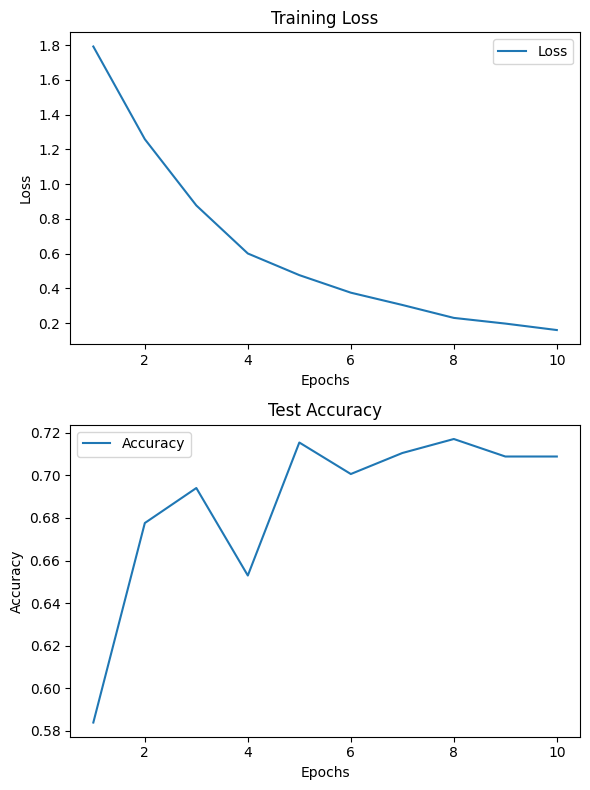

In [35]:
import matplotlib.pyplot as plt

losses = results[0]
accuracies = results[1]
epochs = range(1, len(losses) + 1)


plt.figure(figsize=(6, 8))

plt.subplot(2, 1, 1)
plt.plot(epochs, losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, accuracies, label='Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
get_dev_predictions(model)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


80 98


In [ ]:
files.download('predictions.txt')

In [26]:
s, t = get_model_predictions(model, train_dataloader)
print (len(s), len(t))
print(metrics.confusion_matrix(t, s))
print(metrics.classification_report(t, s))

s, t = get_model_predictions(model, eval_dataloader)
print (len(s), len(t))
print(metrics.confusion_matrix(t, s))
print(metrics.classification_report(t, s))

5521 5521
[[  99    0    0    0    0    0    1    0    0    0    1    1    0    0]
 [   0  432    0    0    0    0    0    0    0    0    0    0    1    1]
 [   0    0  104    0    0    0    0    0    3    0    2    0    4    0]
 [   0    1    0  945    0    0    0    0    2    1   13    0    0    0]
 [   0    0    0    0  134    1    0    0    0    0    3    0    0    0]
 [   1    1    0    0    0  265    0    0    3    0    5    0    0    0]
 [   0    0    0    0    0    0   62    0    1    0    0    1    0    0]
 [   0    0    0    0    0    0    0   62    0    0    0    0    0    0]
 [   1    2    1    9    0    1    1    0 1832    9   29    0    1    0]
 [   0    0    0    0    0    1    0    2   12  406    0    0    1    1]
 [   0    1    9   18    0    0    0    0   16    0  498    0    8    0]
 [   0    0    0    0    0    0    0    0    0    0    0  192    1    0]
 [   0    0    1    0    0    0    0    0    1    0    1    0  213    1]
 [   0    0    0    0    0    0    0    0

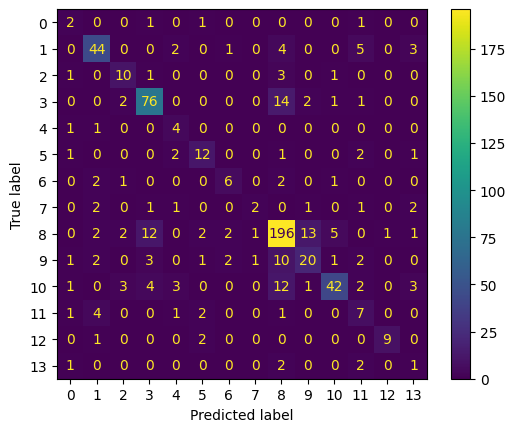

In [32]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(t,s)

from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
